# Prepare dataset for modeling

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import random
from datetime import datetime

import xarray as xr
import glob
import rioxarray

from scipy import ndimage
from scipy.ndimage import binary_erosion

# 1. Parameters

In [3]:
# Directory containing .zarr files
DATA_DIR = "/home/ubuntu/mucilage_pipeline/mucilage-detection/data/adr_test/target"

# Bands to use for analytics
BANDS = ["b02", "b03", "b04", "b8a", "b11", "b12", 'amei', 'ndwi']  # Blue, Green, Red, NIR, NIR narrow, SWIR1, SWIR2

# zarr files
zarr_files = glob.glob(os.path.join(DATA_DIR, "*.zarr"))

# Select month
june_files = [
    f for f in zarr_files
    if os.path.basename(f).split("_")[2][:8][4:6] == "06"
]

# 2. Helper functions

In [4]:
def resample_to_10m(ds, band, ref, folder):
    """
    Resample band to match the resolution & grid of reference band.
    ds: opened .zarr datatree
    band: name of band to resample (string)
    ref: name of reference band (string)
    """
    crs_code = "EPSG:32632"

    # Define reference band
    ref_band = ds[f"measurements/reflectance/r10m/{ref}"]  # reference (10m red)
    ref_band = ref_band.rio.write_crs(crs_code, inplace=True)

    # Band to convert
    if folder == 'measurements':
        band_20m = ds[f"measurements/reflectance/r20m/{band}"]
    else:
        band_20m = ds[f"conditions/mask/l2a_classification/r20m/{band}"] # for classification band
    band_10m = band_20m.rio.write_crs(crs_code, inplace=True)  # ensure CRS

    return band_10m.rio.reproject_match(ref_band)

def compute_amei(ds, eps=1e-6):
    red   = ds["measurements/reflectance/r10m/b04"].values.astype(np.float32)
    green = ds["measurements/reflectance/r10m/b03"].values.astype(np.float32)
    nir   = resample_to_10m(ds, 'b8a', 'b04', folder='measurements')
    nir = nir.values.astype(np.float32)
    swir  = resample_to_10m(ds, 'b11', 'b04', folder='measurements')
    swir = swir.values.astype(np.float32)  # "B11" or "B12"

    # AMEI = (2*red + nir - 2*swir) / (green + 0.25*swir)
    denom = green + 0.25 * swir
    amei  = (2*red + nir - 2*swir) / (denom + eps)  # eps avoids divide-by-zero

    return amei

def compute_ndwi(ds, eps=1e-6):
    green = ds["measurements/reflectance/r10m/b03"].values.astype(np.float32)
    nir   = resample_to_10m(ds, 'b8a', 'b04', folder='measurements')
    nir = nir.values.astype(np.float32)

    # AMEI = (green - nir) / (green + nir)
    ndwi  = (green - nir) / (green + nir + eps)  # eps avoids divide-by-zero

    return ndwi


def build_stack_10m(ds, bands):
    """
    Create (H, W, C) stack from selected bands/indices.
    """
    stack = []
    ref_10m = ds["measurements/reflectance/r10m/b04"]  # reference (10m red)
    
    for b in bands:
        if b in ds['measurements/reflectance/r10m']:   # reflectance at 10m
            arr = ds['measurements/reflectance/r10m'][b].values.astype(np.float32)
        elif b in ds['measurements/reflectance/r20m']: # reflectance at 20m
            arr = resample_to_10m(ds, b, 'b04', folder='measurements')
            arr = arr.values.astype(np.float32)
        elif b == "amei":
            arr = compute_amei(ds)
        elif b == "ndwi":
            arr = compute_ndwi(ds)
        else:
            raise ValueError(f"Band {b} not found or not supported.")
        
        stack.append(arr)
    stack = np.stack(stack, axis=-1)  # (H, W, C)
    return stack

# 3. Patchify

Prepare 256x256xbands patches from each image. Patches are created all over the image (1764 patches for each image)

In [5]:
def extract_patches_3d(array, patch_size=256, stride=256):
    """
    Extract patches from (H, W, C) array.
    Returns a list of patches with shape (patch_size, patch_size, C).
    """
    H, W, C = array.shape
    patches = []

    for i in range(0, H - patch_size + 1, stride):
        for j in range(0, W - patch_size + 1, stride):
            patch = array[i:i+patch_size, j:j+patch_size, :]
            patches.append(patch)
    return patches


def process_folder(zarr_files, bands, patch_size=256, stride=256):
    """
    Loop through all zarr files in a folder and extract patches.
    """
    all_patches = []

    for zf in zarr_files:
        print(f"Processing {zf} ...")
        ds = xr.open_datatree(zf, engine="zarr", mask_and_scale=False)

        stack = build_stack_10m(ds, bands)
        patches = extract_patches_3d(stack, patch_size, stride)
        
        all_patches.extend(patches)
    
    return all_patches

In [4]:
patches = process_folder(zarr_files[:2], BANDS)

print(f"Total patches: {len(patches)}")
print(f"Patch shape: {patches[0].shape}")

Processing /home/ubuntu/mucilage_pipeline/mucilage-detection/data/adr_test/target/S2B_MSIL2A_20240728T095549_N0511_R122_T32TQQ_20240728T114034.zarr ...
Processing /home/ubuntu/mucilage_pipeline/mucilage-detection/data/adr_test/target/S2A_MSIL2A_20240723T100031_N0511_R122_T32TQR_20240723T155949.zarr ...
Total patches: 3528
Patch shape: (256, 256, 8)


Strategic patchify. Generate patches along the water border.

In [ ]:
def sample_patch_centers(water_mask, n_patches, patch_size=256, border_weight=0.7):
    """
    Randomly sample patch centers with more focus on water-land borders.
    """
    H, W = water_mask.shape
    
    # Create a mask from the shoreline (water/land border) expanding seawards
    border_mask = water_mask & ~binary_erosion(water_mask, iterations=300) # choose pixels number
    
    # Probability map
    probs = np.zeros_like(water_mask, dtype=np.float32)
    probs[border_mask] = border_weight   # 70% on border
    probs[water_mask]  = 1.0 - border_weight  # 30% on water
    
    probs = probs / probs.sum()  # normalize to 1
    
    # Flatten and sample indices
    flat_idx = np.random.choice(H*W, size=n_patches, replace=False, p=probs.ravel()) # randomly picks pixel indices based on the prob map (p)
    centers = np.column_stack(np.unravel_index(flat_idx, (H, W))) # convert indices back into (row, col) coordinates in the 2D image
    
    # Convert to (row, col) top-left corners
    half = patch_size // 2 # centering
    corners = [(max(0, r-half), max(0, c-half)) for r, c in centers]
    
    return corners


def extract_patches_focus(stack, water_mask, n_patches=100, patch_size=256):
    """
    Extract (256,256,C) patches with sampling biased toward border regions.
    """
    H, W, C = stack.shape
    corners = sample_patch_centers(water_mask, n_patches, patch_size)
    
    patches = []
    for i, j in corners:
        if i+patch_size <= H and j+patch_size <= W:
            patches.append(stack[i:i+patch_size, j:j+patch_size, :])
    return patches


def process_folder_opt(zarr_files, bands, water_mask):
    """
    Loop through all zarr files in a folder and extract patches.
    """
    all_patches = []

    for zf in zarr_files:
        print(f"Processing {zf} ...")
        ds = xr.open_datatree(zf, engine="zarr", mask_and_scale=False)

        stack = build_stack_10m(ds, bands)
        patches = extract_patches_focus(stack, water_mask)
        
        all_patches.extend(patches)
        del ds, stack # to avoid RAM overload
    
    return all_patches


def plot_patch_grid(patches, n=10, rgb_idx=(2,1,0)):
    """
    Show n x n grid of RGB patches.
    - patches: list of (256,256,C) arrays
    - n: grid size
    - rgb_idx: indices of stack channels to use as RGB (default assumes [b2,b3,b4,...])
    """
    fig, axes = plt.subplots(n, n, figsize=(15, 15))
    fig.subplots_adjust(hspace=0.05, wspace=0.05)

    # pick random patches
    chosen = random.sample(patches, n*n) if len(patches) > n*n else patches[:n*n]

    for ax, patch in zip(axes.flat, chosen):
        # select RGB channels
        rgb = patch[..., list(rgb_idx)]
        rgb = rgb.astype(np.float32)

        # simple normalization (per patch)
        p2, p98 = np.nanpercentile(rgb, (2, 98))
        rgb = np.clip((rgb - p2) / (p98 - p2 + 1e-6), 0, 1)

        ax.imshow(rgb)
        ax.axis("off")

    plt.show()

In [7]:
# Generate water mask
# NOTE: here the water mask is generated from the first file and kept for all the others

dt = xr.open_datatree(june_files[0], engine="zarr", mask_and_scale=False)
scl = resample_to_10m(dt, 'scl', 'b04', folder='conditions') # 10m resolution
scl = scl.squeeze().values
water_mask = (scl == 6)

patches = process_folder_opt(june_files, BANDS, water_mask)

Processing /home/ubuntu/mucilage_pipeline/mucilage-detection/data/adr_test/target/S2A_MSIL2A_20240606T100601_N0510_R022_T32TQQ_20240606T175100.zarr ...
Processing /home/ubuntu/mucilage_pipeline/mucilage-detection/data/adr_test/target/S2B_MSIL2A_20240618T095549_N0510_R122_T32TQQ_20240618T124428.zarr ...
Processing /home/ubuntu/mucilage_pipeline/mucilage-detection/data/adr_test/target/S2A_MSIL2A_20240616T100601_N0510_R022_T32TQQ_20240616T160951.zarr ...
Processing /home/ubuntu/mucilage_pipeline/mucilage-detection/data/adr_test/target/S2B_MSIL2A_20240628T095549_N0510_R122_T32TQQ_20240628T124047.zarr ...
Processing /home/ubuntu/mucilage_pipeline/mucilage-detection/data/adr_test/target/S2B_MSIL2A_20240601T100559_N0510_R022_T32TQQ_20240601T125555.zarr ...


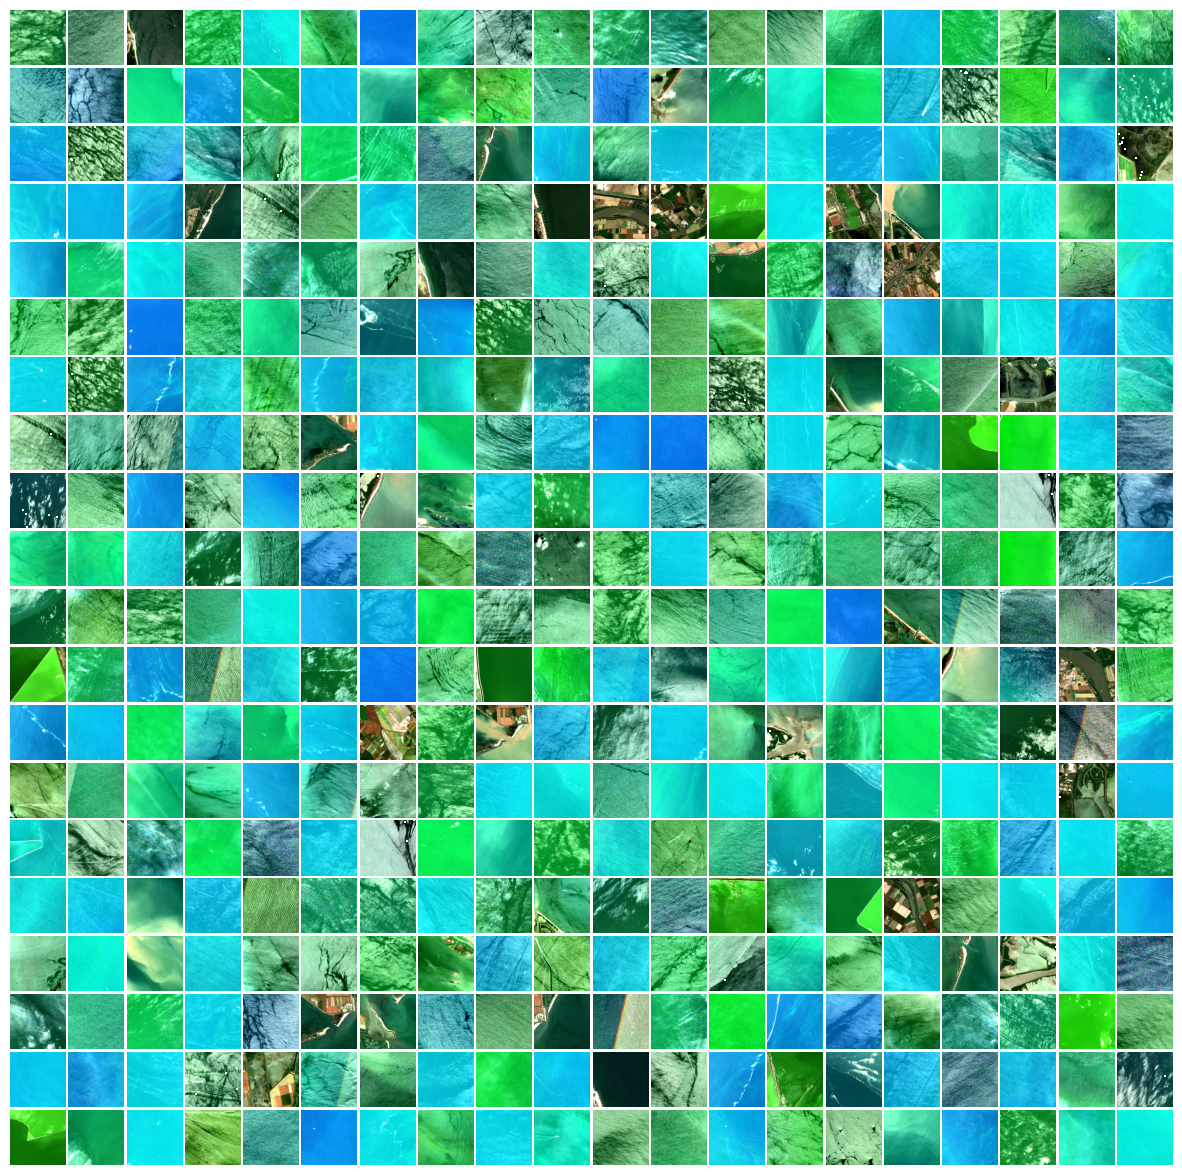

In [8]:
plot_patch_grid(patches, n=20, rgb_idx=(2,1,0))

# 4. Prepare dataset

Split into train/test/validation

In [11]:
# Create (N, 256, 256, 8) array
patches = np.array(patches, dtype=np.float32)

np.random.seed(42)  # reproducibility
np.random.shuffle(patches)

n_total = len(patches)
train_end = int(0.7 * n_total)
val_end   = int(0.85 * n_total)

train_set = patches[:train_end]
val_set   = patches[train_end:val_end]
test_set  = patches[val_end:]

In [12]:
print(train_set.shape)

(2469, 256, 256, 8)
